In [1]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included',
   'title': 'A Comprehensive Guide About Langgraph: Code Included - Ionio',
   'content': 'A node can be any function or tool your agent uses in langgraph and these nodes are connected with other nodes using edges. Every workflow ends with a “END” node in langgraph which shows the end of workflow. You also need to define a starting node which will be the starting point of your workflow.',
   'score': 0.9049283,
   'raw_content': None},
  {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'content': '*   **Stateful Graph:** LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintai

In [2]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")


In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [4]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [5]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

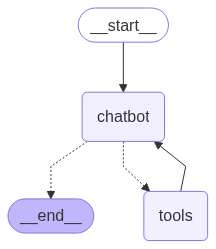

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  What do you know about LangGraph?


Assistant: [{'text': 'Let me search for information about LangGraph.', 'type': 'text'}, {'id': 'toolu_017BWNBjSBZWAQjiMmE1x9K5', 'input': {'query': 'LangGraph framework python langchain what is it'}, 'name': 'tavily_search', 'type': 'tool_use'}]
Assistant: {"query": "LangGraph framework python langchain what is it", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.langchain.com/langgraph", "title": "LangGraph - LangChain", "content": "Design agent-driven user experiences with LangGraph Platform's APIs. Quickly deploy and scale your application with infrastructure built for agents. LangGraph sets the foundation for how we can build and scale AI workloads \u2014 from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. The next chapter in building complex production-ready features with LLMs is agentic, and with LangGraph and LangSmith, LangChain delivers an out-of-the-box solution to iterate quickly,